Using the House Prices dataset from kaggle your task will be to predict the prices of the houses. 

* load dataset from Thinkful PostgreSQL database
* investigate the data, and do any necessary data cleaning.
* explore the data and find some variables that you think would be useful in predicting house prices. 
* Build your initial model using these features and estimate the parameters using OLS. 

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.stats import bartlett
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'
                       .format(postgres_user, postgres_pw, postgres_host,
                              postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [3]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
#one hot encoding categorical variables and creating correlation matrix
one_hot = pd.get_dummies(df, drop_first=True)
corr_df_0 = one_hot.corr()

#examining the variables most correlated with target variable saleprice
corr_df_0['saleprice'].sort_values(ascending=False)

saleprice           1.000000
overallqual         0.790982
grlivarea           0.708624
garagecars          0.640409
garagearea          0.623431
                      ...   
masvnrtype_None    -0.374468
garagefinish_Unf   -0.410608
bsmtqual_TA        -0.452394
kitchenqual_TA     -0.519298
exterqual_TA       -0.589044
Name: saleprice, Length: 247, dtype: float64

In [6]:
#examining the variables most correlated with saleprice
#abosolute values reported here to help rank the magnitude of each correlation 
abs(corr_df_0['saleprice']).sort_values(ascending=False)

saleprice            1.000000
overallqual          0.790982
grlivarea            0.708624
garagecars           0.640409
garagearea           0.623431
                       ...   
foundation_Wood      0.002711
garagecond_Gd        0.000983
roofstyle_Mansard    0.000308
roofmatl_Metal       0.000304
bsmtfintype2_GLQ     0.000076
Name: saleprice, Length: 247, dtype: float64

In [7]:
#finding and dropping values that have less than 5% correlation in either direction with our target variable to shrink feature space
low_corr = corr_df_0.loc[abs(corr_df_0['saleprice']) < .05]
low_corr = low_corr['saleprice'].index
low_corr_list = [x for x in low_corr]

df_pca = one_hot.drop(low_corr_list, axis=1)

c:\python\python37\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\python\python37\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


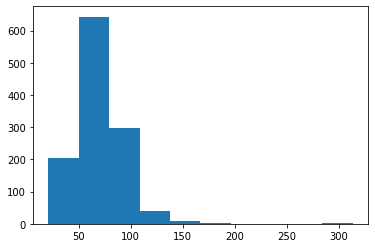

In [8]:
#examining distribution of lotfrantage variable
plt.hist(df_pca['lotfrontage'])
plt.show()

In [9]:
df_pca['lotfrontage'].fillna(df_pca['lotfrontage'].mean(), inplace=True)

In [10]:
#checking correlation between garageyrblt and yearbuild
corr_df_0['garageyrblt'].sort_values(ascending=False)

garageyrblt            1.000000
yearbuilt              0.825667
foundation_PConc       0.661998
yearremodadd           0.642277
garagecars             0.588920
                         ...   
garagefinish_Unf      -0.542316
exterqual_TA          -0.596502
bsmtqual_TA           -0.600124
exterior1st_AsphShn         NaN
extercond_Po                NaN
Name: garageyrblt, Length: 247, dtype: float64

In [11]:
#filling remaining missing values
df_pca['garageyrblt'].fillna(df_pca['yearbuilt'], inplace=True)
df_pca['masvnrarea'].fillna(df_pca['masvnrarea'].mean(), inplace=True)

In [12]:
#checking for any overlooked missing values
df_pca.isnull().sum().sort_values(ascending=False)


salecondition_Partial    0
neighborhood_Mitchel     0
neighborhood_Somerst     0
neighborhood_Sawyer      0
neighborhood_SWISU       0
                        ..
bsmtcond_Gd              0
bsmtqual_TA              0
bsmtqual_Gd              0
bsmtqual_Fa              0
mssubclass               0
Length: 153, dtype: int64

In [13]:
df_pca.dropna(inplace=True)

scaled_df = StandardScaler().fit_transform(df_pca)

sklearn_pca = PCA(n_components=5)

pca_arrays  = sklearn_pca.fit_transform(scaled_df)

ratio = sklearn_pca.explained_variance_ratio_
print(ratio)
print(ratio.sum())

[0.10923791 0.04390671 0.03471298 0.03114333 0.02400093]
0.24300186563416645


In [14]:
df_pca['pca_1'] = pca_arrays[:,0]
df_pca['pca_2'] = pca_arrays[:,1]
df_pca['pca_3'] = pca_arrays[:,2]
df_pca['pca_4'] = pca_arrays[:,3]
df_pca['pca_5'] = pca_arrays[:,4]

In [15]:
corr_df = df_pca.corr()
abs(corr_df['saleprice']).sort_values(ascending=False)

saleprice                1.000000
pca_1                    0.807859
overallqual              0.790982
grlivarea                0.708624
garagecars               0.640409
                           ...   
exterior1st_WdShing      0.051317
exterior1st_BrkComm      0.051264
fence_MnWw               0.051164
salecondition_AdjLand    0.050686
extercond_Gd             0.050467
Name: saleprice, Length: 158, dtype: float64

In [16]:
corr_df.shape

(158, 158)

In [17]:
low_corr_2 = corr_df.loc[abs(corr_df['saleprice']) < .30]
low_corr_2 = low_corr_2['saleprice'].index
low_corr_list_2 = [x for x in low_corr_2]

pca_corr_df = df_pca.drop(low_corr_list_2, axis=1)
pca_corr = pca_corr_df.corr()
pca_corr.shape

(43, 43)

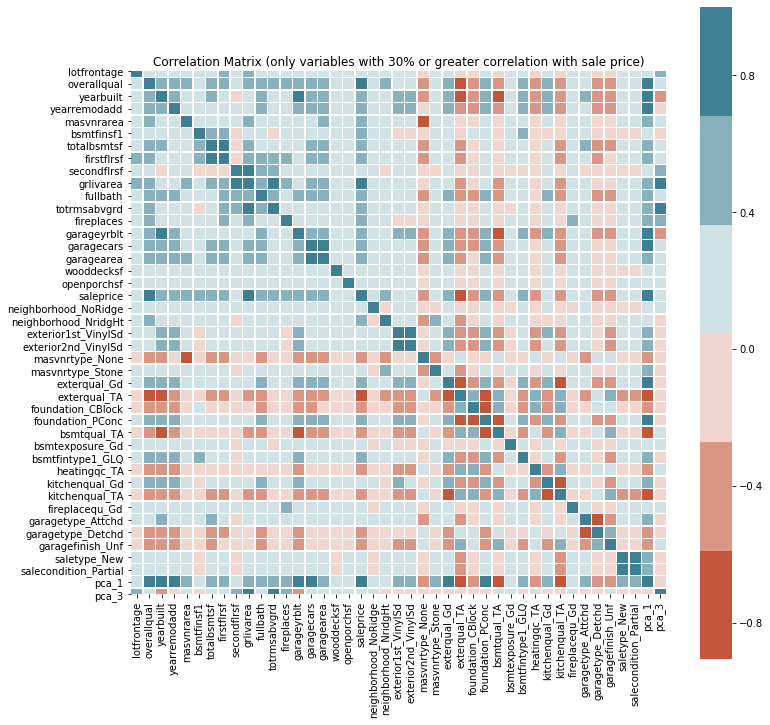

In [18]:
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(
    pca_corr, 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    linewidths=.5).set_title('Correlation Matrix (only variables with 30% or greater correlation with sale price)')

In [19]:
x_coord = df_pca['pca_1']
y_coord = df_pca['saleprice']

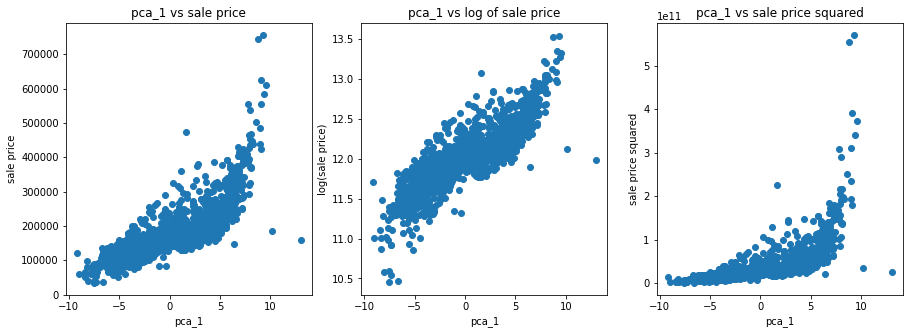

In [20]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x_coord, y_coord)
plt.title('pca_1 vs sale price')
plt.xlabel('pca_1')
plt.ylabel('sale price')

plt.subplot(1,3,2)
plt.scatter(x_coord, np.log(y_coord))
plt.title('pca_1 vs log of sale price')
plt.xlabel('pca_1')
plt.ylabel('log(sale price)')

plt.subplot(1,3,3)
plt.scatter(x_coord, y_coord**2)
plt.title('pca_1 vs sale price squared')
plt.xlabel('pca_1')
plt.ylabel('sale price squared')
plt.show()

In [21]:
x_coord = df_pca['overallqual']
y_coord = df_pca['saleprice']

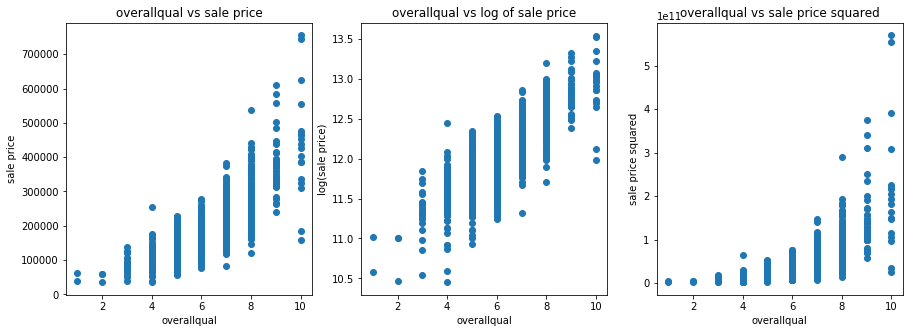

In [22]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(x_coord, y_coord)
plt.title('overallqual vs sale price')
plt.xlabel('overallqual')
plt.ylabel('sale price')

plt.subplot(1,3,2)
plt.scatter(x_coord, np.log(y_coord))
plt.title('overallqual vs log of sale price')
plt.xlabel('overallqual')
plt.ylabel('log(sale price)')

plt.subplot(1,3,3)
plt.scatter(x_coord, y_coord**2)
plt.title('overallqual vs sale price squared')
plt.xlabel('overallqual')
plt.ylabel('sale price squared')
plt.show()

In [23]:
#preparing our matricies for determination of linear 
Y = df_pca['saleprice']
X = df_pca[['pca_1','overallqual']]

#manually adding constant 
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()


c:\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1758.
Date:                Tue, 01 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:41:28   Log-Likelihood:                -17648.
No. Observations:                1460   AIC:                         3.530e+04
Df Residuals:                    1457   BIC:                         3.532e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.171e+04   8543.861      4.882      0.000     2.5e+04    5.85e+04
pca_1        9442.4016    469.577     20.108      0.000    8521.283    1.04e+04
overallqual  2.282e+04   1388.567     16.437      0.000    2.01e+04    2.55e+04
==============================================================================
Omnibus:                      781.393   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14066.676
Skew:                           2.080   Prob(JB):                         0.00
Kurtosis:                      17.626   Cond. No.                         49.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Assumption Verification

Assumption 1: Linearity of the model in its coefficients. 

Our model meets this assumption as we are not squaring or divinding any of our coefficients. All the coefficients are constant across changing independent and depenedent variables. 

Assumption 2: the error term should be zero on average, which we can see below is the case.

In [24]:
#gathering error values using .resid property
errors = results.resid
errors

0      -34677.689833
1        5559.003549
2      -24511.598438
3      -49475.792029
4      -36440.794704
            ...     
1455   -20249.343005
1456    27578.071763
1457    55910.005346
1458    13204.528407
1459     6975.061921
Length: 1460, dtype: float64

In [25]:
#verifying error values manually 
errors_calculated = df_pca['saleprice'] - results.fittedvalues
errors_calculated

0      -34677.689833
1        5559.003549
2      -24511.598438
3      -49475.792029
4      -36440.794704
            ...     
1455   -20249.343005
1456    27578.071763
1457    55910.005346
1458    13204.528407
1459     6975.061921
Length: 1460, dtype: float64

In [26]:
#calculating average of error terms
errors.sum()/len(errors)

1.4390847454332326e-09

We can see that the average of the error terms is effectively zero, so this assumption is satisfied. 

Assumption 3: Homoscedasticity

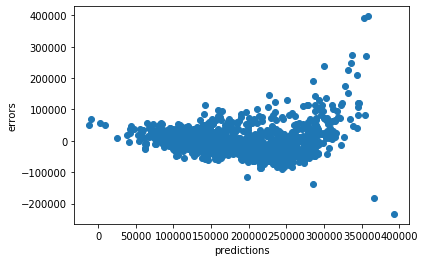

In [27]:
plt.scatter(results.fittedvalues, errors)
plt.xlabel('predictions')
plt.ylabel('errors')
plt.show()

In [28]:
bartlett_stats = bartlett(results.fittedvalues, errors)
levene_stats = levene(results.fittedvalues, errors)

print("Bartlett test statistic value is {} and p value is {}".format(bartlett_stats[0], bartlett_stats[1]))
print("Levene test statistic value is {} and p value is {}".format(levene_stats[0], levene_stats[1]))

Bartlett test statistic value is 274.13660108101715 and p value is 1.4235736752303589e-61
Levene test statistic value is 447.10531767987703 and p value is 1.8839857655648334e-92


We can see that the p-values of both the Bartlett and Levene test are less than 0.05 meaning that we can reject the null hypothesis of homoscedasticity. This means that our errors are heteroscedastic. Having heteroscedastic errors means that our model will be too confident in its predictions. We can see from the distribution of the errors above that our variance changes systematically. We tend to have a low amount of variation for cheaper homes while we have a much wider range for more expensvie homes. We should be weary of predictions made by some statistical tests like the t-test and F-test. Heteroscedasticity may also make some estimated coefficients seem more statistically significant. 

Assumption 4: Low multicollinearity 

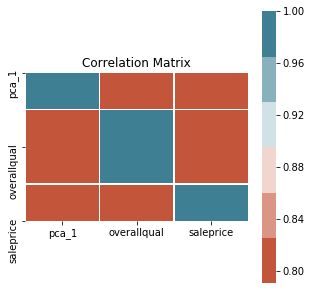

In [29]:
co_lin_df = pd.DataFrame()
co_lin_df = df_pca[['pca_1','overallqual', 'saleprice']]

fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(
    co_lin_df.corr(), 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    linewidths=.5).set_title('Correlation Matrix')

From the heatmat of our correlation matrix we can see that we have a high degree of co-linearity between the features that were used to predict our target variable. This is not a problem for prediction but it means we will not be able to properly expalin where the variance comes from. This will make it difficult to distinguish which variables matter most for the prediction of our target variable. 

Assumption 5: error terms should be uncorrelated with one another. 

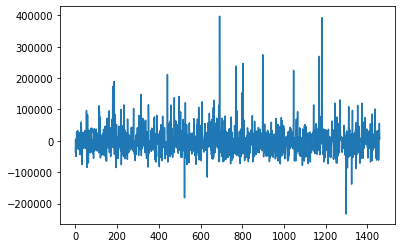

In [30]:
plt.plot(errors)
plt.show()

c:\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


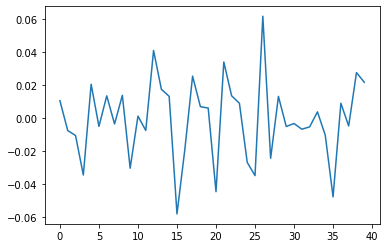

In [31]:
error_data = acf(errors)
plt.plot(error_data[1:])
plt.show()

Based on the plots above it seems as though our errors do not have any predictable pattern. There appears to be no autocorrelation. 

Assumption 6: Features shouldn't be correlated with errors

c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


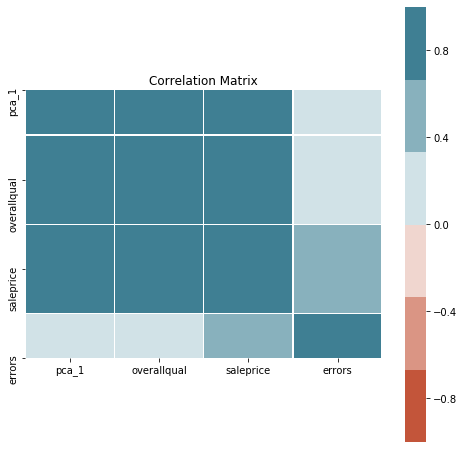

In [41]:
co_lin_df['errors'] = errors


fig = plt.figure(figsize=(8,8))
ax = sns.heatmap(
    co_lin_df.corr(), 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    vmin=-1,
    vmax=1,
    linewidths=.5).set_title('Correlation Matrix')

In [37]:
 co_lin_df.corr()

,pca_1,overallqual,saleprice,errors
pca_1,1.000000e+00,8.098304e-01,0.807859,7.606241e-16
overallqual,8.098304e-01,1.000000e+00,0.790982,1.721035e-15
saleprice,8.078585e-01,7.909816e-01,1.000000,5.413202e-01
errors,7.606241e-16,1.721035e-15,0.541320,1.000000e+00


From the correlation matrix above it appears as though none of our features are significantly correlated with the errors. The highest correlation is found with our target variable saleprice which is 0.54.